# Feature evaluation
This notebook explores the engeineered features.

## Load dependencies

In [16]:
import os
import json
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

from definitions import GEN_PATH, ROOT_DIR

## Load processed data

In [7]:
# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

## Extract training (and validation) data
Test data should not be used, even in, feature evaluation.

In [33]:
# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400
drop_cols = ['outcome', 'tourney_date', 'tourney_level']

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train = pd.get_dummies(X_train, columns=['home_advantage'])
renames = {
    'home_advantage_-1': 'p2_home',
    'home_advantage_0': 'none_home',
    'home_advantage_1': 'p1_home',
}

X_train.rename(columns=renames, inplace=True)
display(X_train)

,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,p2_home,none_home,p1_home
0,-0.508004,-0.545131,0.005630,0.005705,0.005682,0.099875,-0.119609,-0.563148,-1.750825,-0.002903,1,0,0
1,-0.457910,-0.255181,0.005630,0.005705,0.005682,0.232153,-0.272639,-0.178000,-0.317954,-0.002903,0,1,0
2,-0.057161,-0.213760,0.005630,0.005705,0.005682,0.363038,-0.489623,0.164353,-0.190588,-0.002903,0,0,1
3,0.493870,-0.048074,0.893785,0.885323,0.674916,0.041394,-0.054514,0.677884,-0.190588,-0.002903,0,1,0
4,-0.157348,-0.627974,0.005630,0.005705,0.005682,0.081774,-0.094485,-0.135206,-1.973716,-0.002903,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31021,1.545836,-0.006653,0.005630,0.005705,0.005682,-0.349869,0.003729,1.063031,0.796501,-0.002903,1,0,0
31022,0.293495,-0.420867,0.005630,0.005705,0.005682,-0.497464,0.037989,0.335530,-0.286112,-0.002903,0,1,0
31023,-1.559970,-0.213760,0.005630,0.005705,0.005682,1.068984,-0.067076,-1.461826,-0.986627,-0.002903,0,1,0
31024,0.443776,0.159033,0.005630,0.005705,0.005682,-0.022656,0.003729,0.249942,-0.381637,-0.002903,0,1,0


# Correlation heatmap

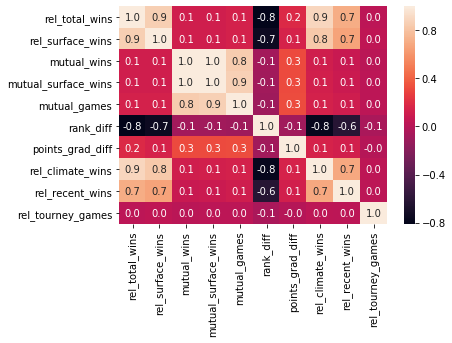

In [34]:
# uncomment to remove highly correlated features
# which "explain" our data less good 
#X_train.drop(['rel_total_wins', 'mutual_wins', 'mutual_surface_wins', 'rel_climate_wins'], inplace=True, axis=1)

adv = ['p2_home', 'none_home', 'p1_home']
X_heat = X_train.drop(adv, axis=1)
sn.heatmap(X_heat.corr(), annot=True, fmt='.1f')
plt.show()

Train base model to be used for feature selection

In [26]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Feature importance
Question being answered: which features help split our tree in the best way possible?
How does each feature affect the accuracy of our model?

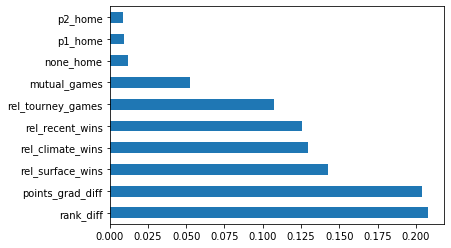

In [27]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

## Recursive feature elimination by feature importance
This takes a bit of time (large set...). 
Prune the results from previous sections. 
A ranking of 1 means the algorithm suggests the feature.
Remove highly correlated feature first

In [21]:
rfe_model = RFE(model)  # selects 5 features
rfe_model.fit(X_train, y_train)

rfe_results = pd.DataFrame(rfe_model.ranking_, index=X_train.columns, columns=['ranking'])

display(rfe_results)
print('\nNumber of features selected: %d' % rfe_model.n_features_)

,ranking
rel_total_wins,1
rel_surface_wins,1
mutual_wins,4
mutual_surface_wins,5
mutual_games,3
rank_diff,1
points_grad_diff,1
rel_climate_wins,1
rel_recent_wins,1
rel_tourney_games,2



Number of features selected: 6


## Removing low level matches
Testing to remove low level matches to see if differen
is present for tour level matches.
